<a href="https://colab.research.google.com/github/partha074/calculator/blob/master/Hyperspectral_Image_Analysis%E2%80%8A_%E2%80%8AClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color = 'tomato'>Hyperspectral Image Analysis - Classification</font>

## Import Libraries

In [ ]:
import plotly.express as px
import matplotlib.pyplot as plt
import numpy as np
sns.axes_style('whitegrid');
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sn

## Download HSI Data

In [ ]:
!wget http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat

--2020-08-20 09:02:14--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M) [text/plain]
Saving to: ‘Indian_pines_corrected.mat.1’

Indian_pines_correc 100%[===================>]   5.68M   713KB/s    in 9.3s    

2020-08-20 09:02:24 (626 KB/s) - ‘Indian_pines_corrected.mat.1’ saved [5953527/5953527]

--2020-08-20 09:02:24--  http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1125 (1.1K) [text/plain]
Saving to: ‘Indian_pines_gt.mat.1’

Indian_pines_gt.mat 100%[===================>]   1.10K  --.-KB/s    in 0s      

2020-08-20 09:02:24 (150 MB/s) - ‘Indian_pines_gt.mat.1’ saved [1125/1125]

FINISHED --2020-08-20 09:02:24--
Total 

In [ ]:
!ls

Dataset.csv		      Indian_pines_gt.mat.1  IP_PCA_Bands.png
Indian_pines_corrected.mat    IP_40_PCA.csv	     sample_data
Indian_pines_corrected.mat.1  IP_Bands.png
Indian_pines_gt.mat	      IP_GT.png


## Read the Data

In [ ]:
from scipy.io import loadmat

def read_HSI():
  X = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
  y = loadmat('Indian_pines_gt.mat')['indian_pines_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (145, 145, 200)
y shape: (145, 145)


### Visualize Bands

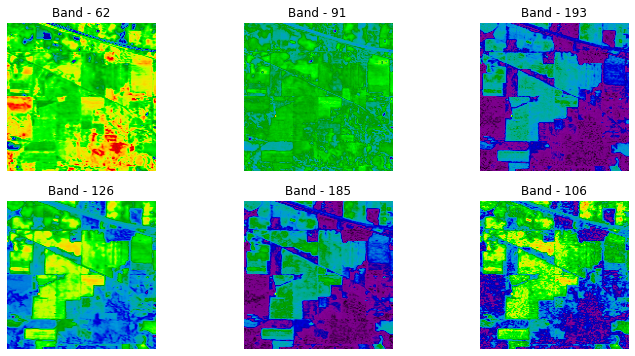

In [ ]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('IP_Bands.png')

### Visualize the Ground Truth

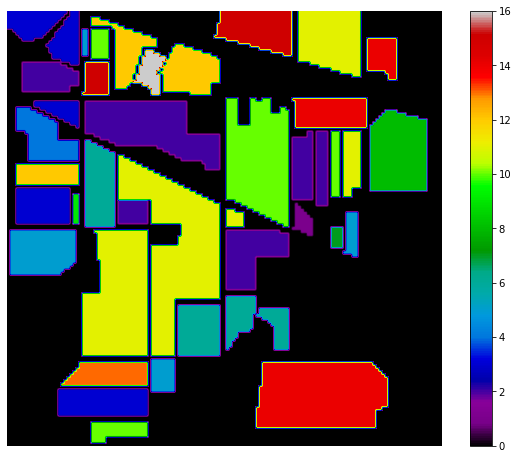

In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_GT.png')
plt.show()

## Convert the dataset into csv 

In [ ]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(X, y)


In [ ]:
df.head()

band1  band2  band3  band4  band5  ...  band197  band198  band199  band200  class
0   3172   4142   4506   4279   4782  ...     1069     1057     1020     1020      3
1   2580   4266   4502   4426   4853  ...     1085     1064     1029     1020      3
2   3687   4266   4421   4498   5019  ...     1092     1061     1030     1016      3
3   2749   4258   4603   4493   4958  ...     1088     1060     1030     1006      3
4   2746   4018   4675   4417   4886  ...     1087     1052     1034     1019      3

[5 rows x 201 columns]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21025 entries, 0 to 21024
Columns: 201 entries, band1 to class
dtypes: uint16(200), uint8(1)
memory usage: 8.0 MB


In [ ]:
df.iloc[:, :-1].describe()

band1         band2  ...       band199       band200
count  21025.000000  21025.000000  ...  21025.000000  21025.000000
mean    2957.363472   4091.321237  ...   1015.571463   1008.513579
std      354.918708    230.390005  ...     11.386402      7.050921
min     2560.000000   2709.000000  ...    986.000000    981.000000
25%     2602.000000   3889.000000  ...   1006.000000   1004.000000
50%     2780.000000   4106.000000  ...   1014.000000   1009.000000
75%     3179.000000   4247.000000  ...   1024.000000   1014.000000
max     4536.000000   5744.000000  ...   1076.000000   1036.000000

[8 rows x 200 columns]

## Principal Component Analysis(PCA)


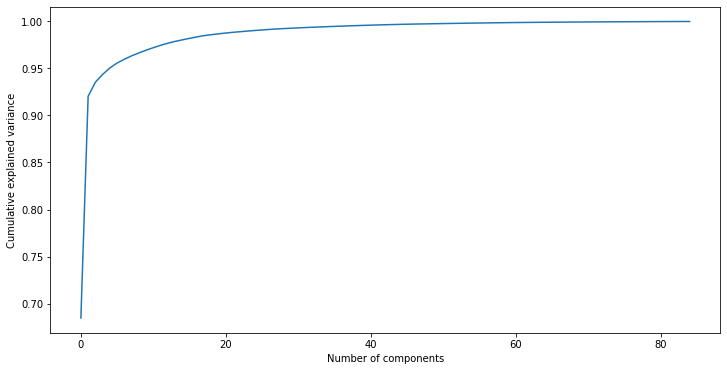

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 85)

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()


Select 40 as the no.of components for PCA

In [ ]:
pca = PCA(n_components = 40)
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,41)]+['class']

In [ ]:
q.head()

PC-1         PC-2        PC-3  ...      PC-39      PC-40  class
0  5014.905985  1456.863260   72.697049  ...  64.302176   9.164323      3
1  5601.383743 -2023.450087  350.134661  ...  14.001741  43.235416      3
2  5796.135442 -3090.394852  490.539929  ... -38.601913  90.514378      3
3  5586.204575 -2369.376085  356.274719  ...  -2.037769  59.314989      3
4  5020.990792   339.603390  -23.007525  ...  60.180896  12.563313      3

[5 rows x 41 columns]

### Display the bands after PCA

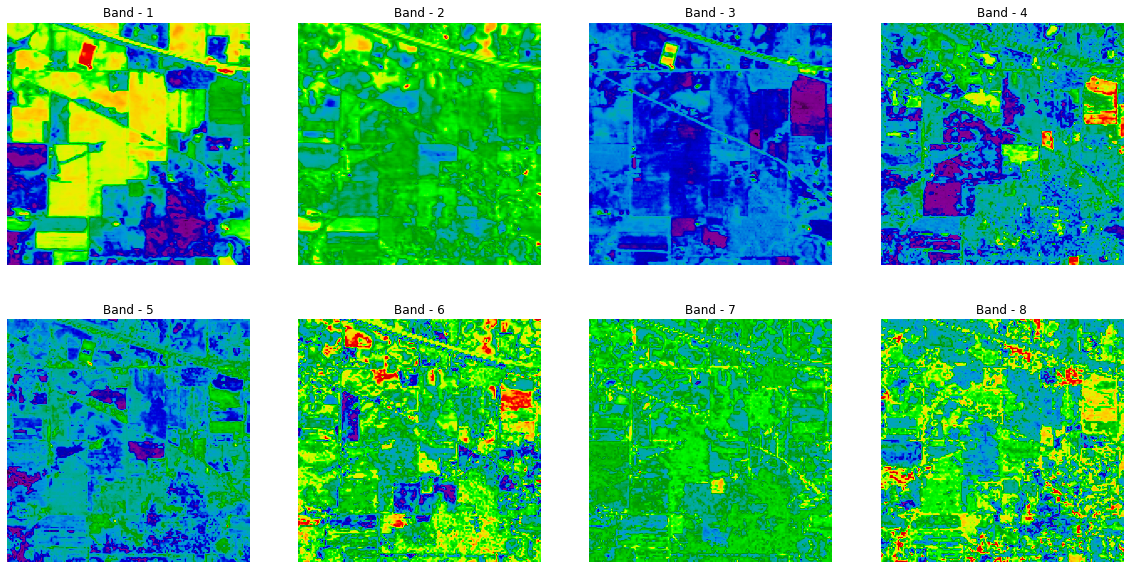

In [ ]:
fig = plt.figure(figsize = (20, 10))

for i in range(1, 1+8):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(145, 145), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')

plt.savefig('IP_PCA_Bands.png')

In [ ]:
# saving to .csv
q.to_csv('IP_40_PCA.csv', index=False)

## Support Vector Machine(SVM)


In [ ]:
x = q[q['class'] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 

names = ['Alfalfa',	'Corn-notill', 'Corn-mintill',	'Corn',		'Grass-pasture','Grass-trees',
'Grass-pasture-mowed','Hay-windrowed','Oats','Soybean-notill','Soybean-mintill',
'Soybean-clean', 'Wheat',	'Woods',	'Buildings Grass Trees Drives',	'Stone Steel Towers']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11, stratify=y)

svm =  SVC(C = 100, kernel = 'rbf', cache_size = 10*1024)

svm.fit(X_train, y_train)

ypred = svm.predict(X_test)

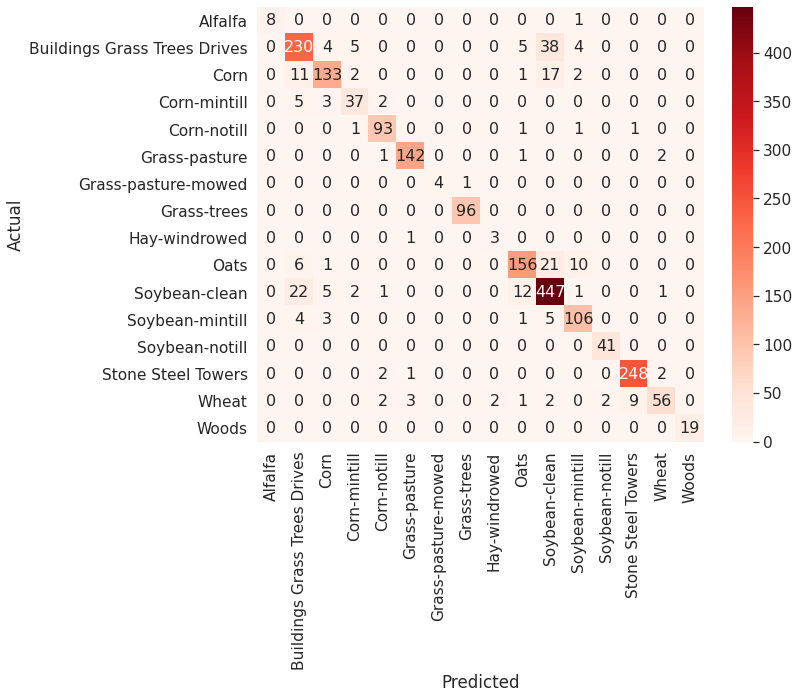

In [ ]:
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [ ]:
print(classification_report(y_test, ypred, target_names = names))

                              precision    recall  f1-score   support

                     Alfalfa       1.00      0.89      0.94         9
                 Corn-notill       0.83      0.80      0.82       286
                Corn-mintill       0.89      0.80      0.84       166
                        Corn       0.79      0.79      0.79        47
               Grass-pasture       0.92      0.96      0.94        97
                 Grass-trees       0.97      0.97      0.97       146
         Grass-pasture-mowed       1.00      0.80      0.89         5
               Hay-windrowed       0.99      1.00      0.99        96
                        Oats       0.60      0.75      0.67         4
              Soybean-notill       0.88      0.80      0.84       194
             Soybean-mintill       0.84      0.91      0.88       491
               Soybean-clean       0.85      0.89      0.87       119
                       Wheat       0.95      1.00      0.98        41
                   

## Classification Map

In [ ]:
l=[]
for i in range(q.shape[0]):
  if q.iloc[i, -1] == 0:
    l.append(0)
  else:
    l.append(svm.predict(q.iloc[i, :-1].values.reshape(1, -1)))


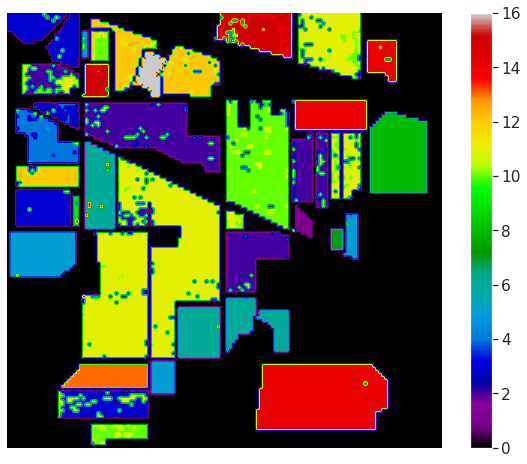

In [ ]:
clmap = np.array(l).reshape(145, 145).astype('float')
plt.figure(figsize=(10, 8))
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('IP_cmap.png')
plt.show()



---



---

